### 1. 〈서울시 인터넷 쇼핑몰 100개 평가 정보〉 전체평가 순위 변동 상위 10위 (2019 → 2020) 그래프  
- 2019년도 대비 2020년도 전체평가 순위가 변동한 데이터 중에서 가장 큰 순위변동이 있었던 상위 10개 브랜드의 변동 크기를 막대그래프로 시각화하였다.

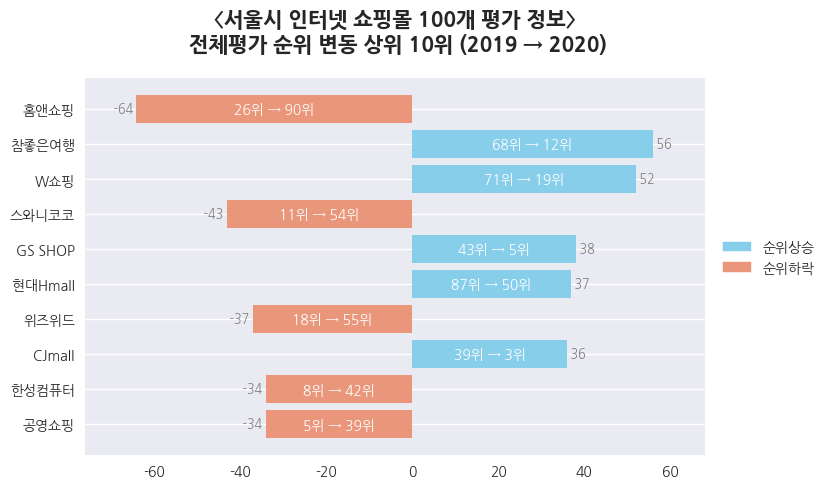

In [40]:
## 오라클 연동하여 시각화할 데이터 추출 ##
import cx_Oracle
import pandas as pd

dsn = cx_Oracle.makedsn("DESKTOP-L3FTR39", 1521, 'xe') 
db = cx_Oracle.connect('c##scott', 'tiger', dsn)
cursor = db.cursor() 
cursor.execute(""" select * from shop100 """) 
row = cursor.fetchall() 
shop = pd.DataFrame(row)
colname = cursor.description 
col = []

for i in colname: 
    col.append(i[0])
    
shop.columns = col

# 2019년도와 2020년도 데이터 가져오기
shop2020 = shop[:][shop['평가년도'] == 2020]
shop2019 = shop[:][shop['평가년도'] == 2019]

# 순위 칼럼 추가
shop2020['순위'] = shop2020['전체평가'].rank(ascending = False).astype('int')
shop2019['순위'] = shop2019['전체평가'].rank(ascending = False).astype('int')

# 순위를 기준으로 정렬
shop2020 = shop2020.sort_values(by = '순위')
shop2019 = shop2019.sort_values(by = '순위')

# 데이터 정제
shop2020['쇼핑몰명'] = shop2020['쇼핑몰명'].replace(['CJ mall', '스트릿패션 라걸', '아싸컴 '], ['CJmall', '라걸', '아싸컴'])
shop2019['쇼핑몰명'] = shop2019['쇼핑몰명'].replace(['갤러리아 백화점', '더블유쇼핑', '아모레퍼시픽쇼핑몰', '롯데하이마트', '홈플러스 쇼핑몰','롯데닷컴', '전자랜드 '], 
                                            ['갤러리아몰', 'W쇼핑', '아모레퍼시픽몰', '하이마트', '홈플러스', '롯데온', '전자랜드'])

# 2020년도 2019년도 데이터 조인
result = pd.merge(shop2020, shop2019, on= ['쇼핑몰명'], suffixes = ('_2020', '_2019'))

# result '순위변화' 칼럼 추가
result['순위변화'] = (result.순위_2019 - result.순위_2020).astype('int')

# 순위변화를 절댓값 순으로 정렬
rank_change = result[['쇼핑몰명', '순위변화', '순위_2019', '순위_2020']].sort_values(by = '순위변화', ascending = False, key = abs)

# 순위변화가 가장 큰 10개의 쇼핑몰 목록
rank_change = rank_change.head(10)

## 그래프 그리기 ##
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib

# 테마 변경
plt.style.use(['seaborn'])

# 한글 폰트 사용
font_path = "c:/Windows/Fonts/NanumGothic.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font_name)

# - 표시 나타나게 함
matplotlib.rcParams['axes.unicode_minus'] = False

# 1x1 figure matrix 생성
fig, ax = plt.subplots(1, 1, figsize = (8, 5), dpi = 100)

# barh그래프 생성
rank_graph = ax.barh(rank_change['쇼핑몰명'],
                     rank_change['순위변화'], 
                     color = (rank_change['순위변화'] > 0).map({True: 'skyblue', False: 'darksalmon'}))

# y축 순서 반전
ax.invert_yaxis()

# x축 양쪽에 간격 추가
ax.set_xmargin(0.1)

# 그리드 설정
ax.set_axisbelow(True) # 그리드가 바 뒤에 오게 설정
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# title 설정
title = '〈서울시 인터넷 쇼핑몰 100개 평가 정보〉\n 전체평가 순위 변동 상위 10위 (2019 → 2020)' # 제목
title_dict = {'fontsize' : 15,
              'fontweight' : 'bold'}

ax.set_title(title,
             pad = 20, 
             fontdict = title_dict)

# 그래프 값 표시하기
for i,x in enumerate(rank_change['쇼핑몰명'].values):
    ax.text(rank_change['순위변화'].values[i], 
            x, 
            ' ' + str(rank_change['순위변화'].values[i]) + ' ',
            fontsize = 9, 
            color ='gray',
            horizontalalignment = 'left' if rank_change['순위변화'].values[i] > 0 else 'right',  
            verticalalignment = 'center')
    
# 막대 그래프 내부 순위 변동 표시
for i,x in enumerate(rank_graph.patches):
    left, bottom, width, height = x.get_bbox().bounds
    ax.annotate( (str(rank_change['순위_2019'].values[i]) + '위 → ' + str(rank_change['순위_2020'].values[i]) + '위' ),
                 (left + width/2, bottom + height/1.5),
                 ha = 'center', 
                 size = 10, 
                 color = 'white')
    
# 범례 설정을 위한 변수 생성
import matplotlib.patches as mpatches
up_rank = mpatches.Patch(color = 'skyblue', label = '순위상승')
down_rank = mpatches.Patch(color = 'darksalmon', label = '순위하락')

# 범례 설정
ax.legend(handles = [up_rank, down_rank],
          loc = 'upper left',
          bbox_to_anchor = (1.01, 0.6),
          fontsize = 10)

plt.show()